In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ee.Initialize()

In [2]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR")
rgbVis = {
  'min': 0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2']
};

In [3]:
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000).select("B.*").copyProperties(image, ["system:time_start"])

In [4]:
def create_s2_composite(geometry, start_date, end_date):
    composite_s2 = s2 \
                .filter(ee.Filter.bounds(geometry)) \
                .filter(ee.Filter.date(start_date, end_date)) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                .map(mask_s2_clouds) \
                .select('B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B11') \
                .median() \
                .clip(geometry)
    return composite_s2

In [5]:
geo = ee.Geometry.Polygon(
        [[[29.554, 3.159],
          [29.554, 3.092],
          [29.625, 3.092],
          [29.625, 3.159]]])

c = create_s2_composite(geo, '2021-01-01', '2021-12-31')

In [16]:
def gee_line_to_pandas(line, num_points):
    def merge_lat_lon(x_coord):
        y_coord = y_map_list.get(x_map_list.indexOf(x_coord))
        return ee.Feature(ee.Geometry.Point([x_coord, y_coord]))

    point1 = ee.List(line.coordinates().get(0))
    point2 = ee.List(line.coordinates().get(1))
    
    x_map_list = ee.List.sequence(point1.get(0), point2.get(0), None, num_points)
    y_map_list = ee.List.sequence(point1.get(1), point2.get(1), None, num_points)
    points = ee.FeatureCollection(x_map_list.map(merge_lat_lon))
    
    composite = create_s2_composite(geo, '2021-01-01', '2021-12-31')
    image = composite.rename(['Blue', 'Green', 'Red', 'Red Edge 1', 'Red Edge 2', 'NIR', 'SWIR 1'])
    with_band_values = image.reduceRegions(points, ee.Reducer.first(), 10)
    df = geemap.ee_to_pandas(with_band_values)
    return df

In [18]:
def plot(cross_section, image_path):
    df = gee_line_to_pandas(cross_section, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    fig.suptitle('"Main Title"')
    
    img = mpimg.imread(image_path)
    ax1.imshow(img)
    ax1.axis('off')
    ax1.title.set_text('2021 Median Composite')
    
    df.plot(ax=ax2,
        title='Sentinel-2 Band Values Over Cross Section',
        ylabel='Band Value',
        color=['blue', 'green', 'red', 'orange', 'yellow', 'purple', 'pink'])

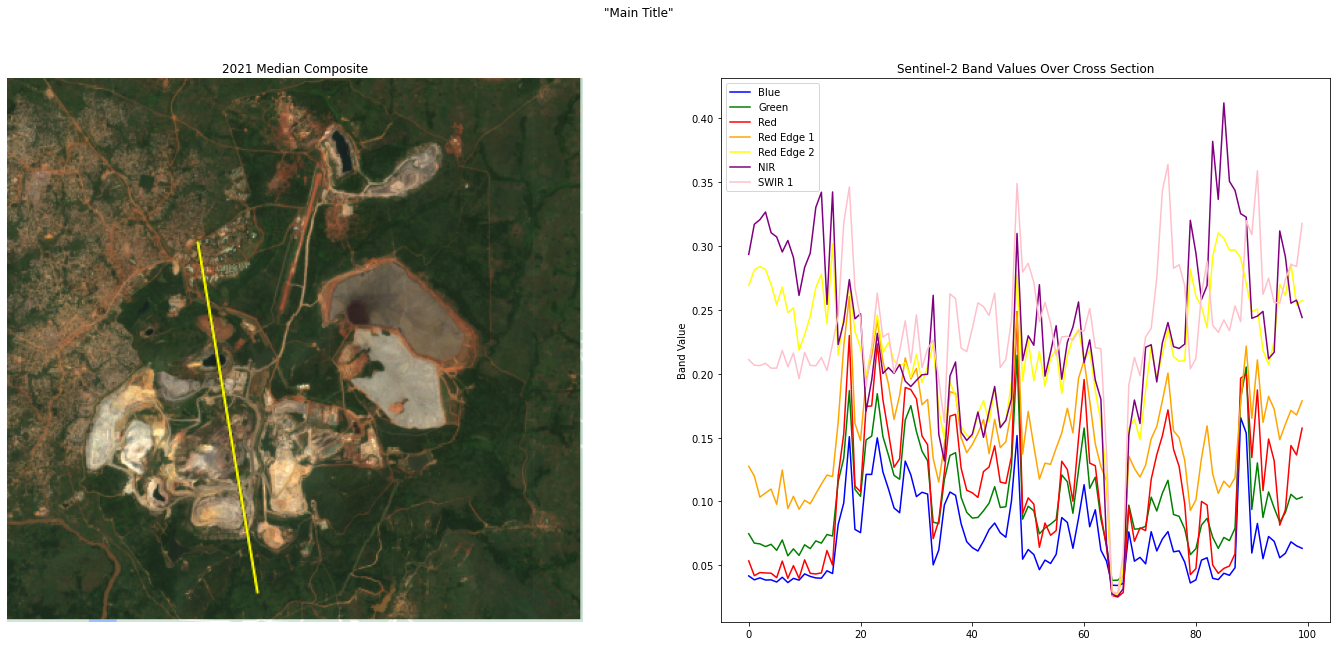

In [19]:
cross_section = ee.Geometry.LineString([[29.58504431490212, 3.095409327883319], [29.577619960348898, 3.138603995873558]])
path='notebooks/with_cs.PNG'
plot(cross_section, path)